In [1]:
from segmentation_algorithms.topdown_index import XTSTreeTopDownIndex
from segmentation_algorithms.topdown_reg import XTSTreeTopDownReg
from XTSTree.XTSTreePageHinkley import XTSTreePageHinkley

import pandas as pd
import numpy as np
from plot import plot

In [2]:
series = pd.read_csv('./datasets/base datasets/23025122/export_automaticas_23025122_tempmedar2m.csv')['tempmedar2m'][:96*20]

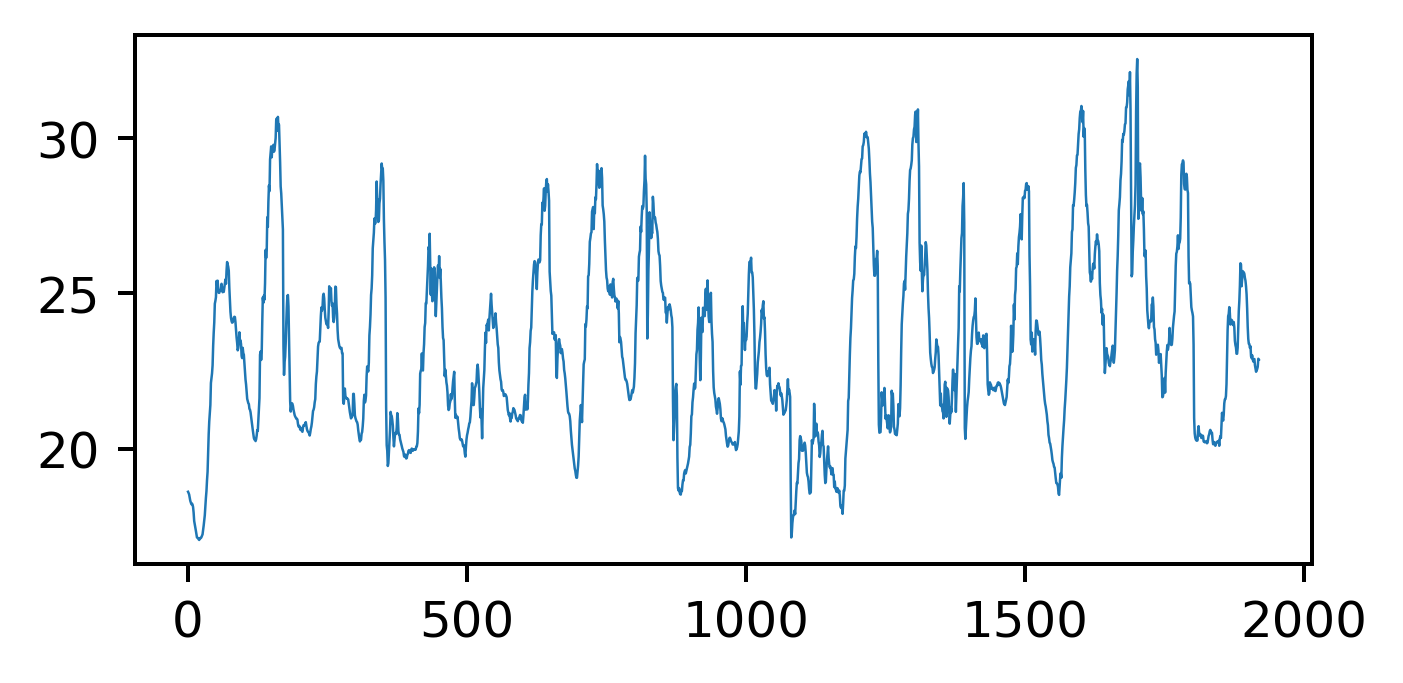

In [3]:
plot(series)

In [4]:
ph_model = XTSTreePageHinkley(stop_condition='adf', stop_val=0.5, max_iter=100, min_dist=0)

In [5]:
ph_model.create_splits(series)

Não achei só um corte, escolhendo corte que gera maior pontuação, 1634, 693.1270119411215, 0, 6
Série pequena demais para adf, deve terminar o corte
Série pequena demais para adf, deve terminar o corte


TypeError: __repr__ returned non-string (type dict)

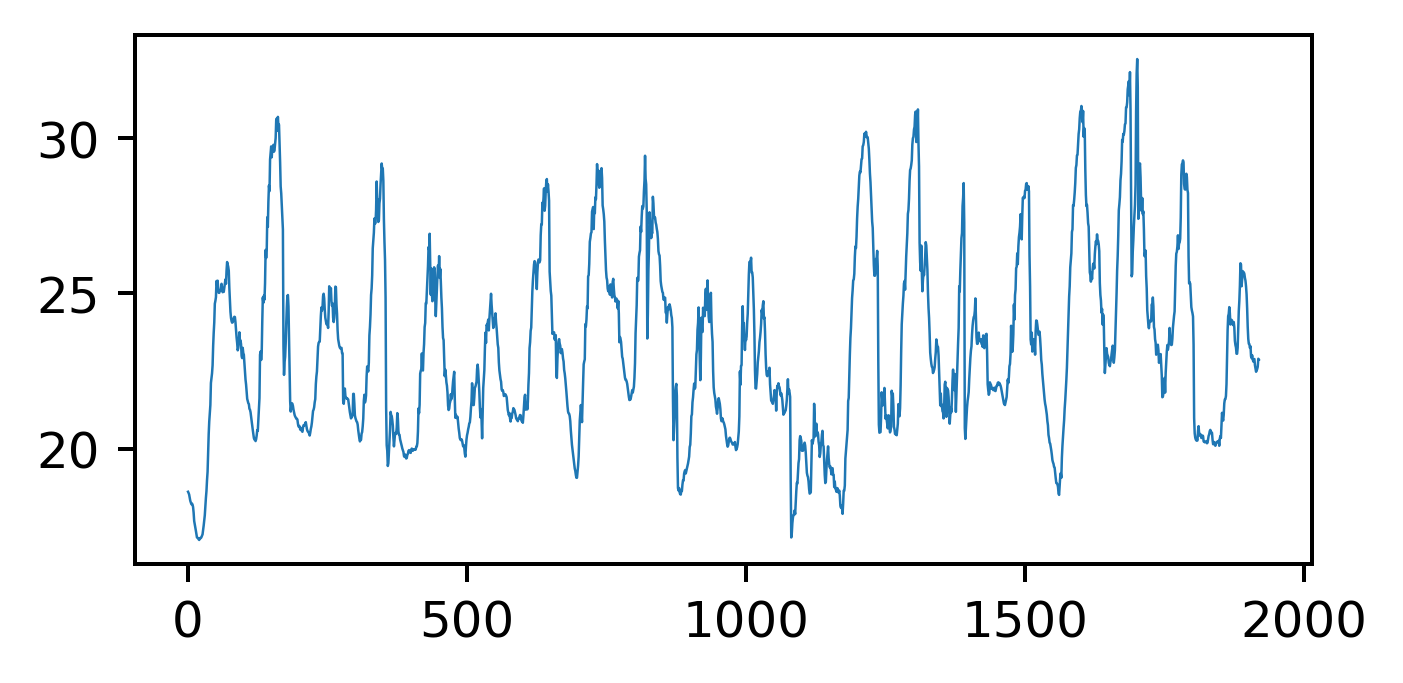

In [13]:
a = ph_model.cut_series(series)
plot(series, divisions=ph_model.cut_points())